# Competitive McCall Job Search Model using the Hungarian Matching Algorithm

James Yu, 13 March 2021

## Sources Preamble

This notebook sources theory and mathematics from [these notes on the McCall model by Dr. Jesse Perla](https://github.com/jlperla/ECON307_2021/blob/main/lecture_notes/search.pdf) and [this previous notebook on the Hungarian Algorithm by myself based on notes from Dr. Michael Peters](https://github.com/jbrightuniverse/Hungarian-Algorithm-No.-5/blob/main/HungarianAlgorithm.ipynb). It also derives theory from [these notes on sample variance distribution by PennState Uni](https://online.stat.psu.edu/stat414/lesson/26/26.3), [this numerical implementation of the default McCall search model in QuantEcon](https://python.quantecon.org/mccall_model.html), and [these notes on a linear algebra method of linear and quadratic interpolation by Dr. Patrick Walls](https://www.math.ubc.ca/~pwalls/math-python/linear-algebra/applications/#polynomial-interpolation).

## Intro

The McCall Job Search Model is a mathematical formulation for modelling the procedure by which individuals search for work in the labour market. In the basic model, a particular individual is faced with an intertemporal choice between wages drawn from an interval each period following a continuous random distribution. Each period, they can either reject this wage, in which case they are paid unenmployment benefits; or they can accept the wage, which will be their wage infinitely into the future. The goal is to figure out when to stop rejecting wages by finding a particular wage threshold above which to accept a wage offer.

The Hungarian Algorithm is an algorithm which, given a set of workers and a set of firms along with the revenues each firm gets from hiring a particular worker, will find a complete matching of workers to firms such that the total revenue across all firms is maximized. This matching splits the revenue as wages to the workers and profits to the firms, and has the property that no worker or firm can do any better by deviating from this optimal matching.

The key characteristic of the McCall model is that the wages drawn each period are encapsulated by the probability density function of the random variable defining these wages. This allows the random variable to be specified explicitly.

This notebook explores what would happen if we employed the Hungarian Algorithm over a random distribution of workers and firms to define one such random variable outputting an optimal wage for one such worker in a competitive environment, which can then be used in the McCall model to determine the threshold wage by which to start accepting offers.

## Goal

The goal of this upgraded model is to compute the optimal strategy for accepting and declining job offers in a market where we have many workers and many firms.

## Initial Assumptions and Definitions

To start, we must define the constraints of the proposed model. These determine what the model can actually be applied to. We have the following definitions and constraints:

- Workers
    - Workers are individuals with a type $t_w$ which defines their baseline productivity in any given firm. This type may be defined using worker characteristics, such as GPA, university credits, personal projects, etc.
    - $t_w \geq 0$.
    - $t_w = 0$ corresponds to a "degenerate agent" classification used as a placeholder for a firm not hiring any workers. We assume that a worker with $t_w = 0$ provides no benefit or productivity to a firm, which is equivalent to not hiring any workers at all.
    - Given a set of firms with job openings, all workers apply to all of them. If not, we could just pretend they applied to firms they didn't apply to by using $t_w = 0$. Quantifying the cases where a worker chooses not to apply to a firm is out of the scope of this notebook so we assume everyone applies everywhere. This also allows us to not have to declare firm wages in advance.
    - All workers have a similar basic skillset. That is, these are workers of a particular field applying to firms of a particular field such as finance, software engineering, market analysis, etc.
    - All workers have some intuition as to the types $t_{-w}$ of the other workers. Data such as class averages is usually publicly known, so this is a reasonable assumption to make.
    - All workers have some intuition as to the revenues of the firms. Firms usually publish earnings data, so this is also a reasonable assumption. It may be safe to assume that the size and/or public knowledge of a company may have some correlation to revenue as well, but proving this hypothesis is out of the scope of this notebook and the initial assumption is sufficient.

- Firms
    - Firms are companies which make revenue wholly dependent on finding a worker to employ. That is, firms have revenue $R(t_w, r_f)$ where $t_w$ is the type of the worker hired at the firm, and $r_f$ is an efficiency multiplier which dictates how well a firm is able to translate the abilities of any worker into tangible revenue.
    - $R(t_w, r_f) = t_w * r_f$. That is, a firm's revenue is based exclusively on how well they can use the output of a worker they employed.
    - $t_w = 0$ is equivalent to a firm having employed nobody, in which case they receive revenue $r_f * 0 = 0$.
    - $r_f \geq 0$.
    - $r_f = 0$ corresponds to a firm which makes no revenue regardless of workers they hire. For simplicity, we will use this to represent a worker remaining unemployed and we will externally add unemployment benefits if this happens.
   - Firms know with certainty what the types of the workers applying to each firm are. This data would be available through metrics such as resumes and university transcripts.
   - Firms have some intuition as to the revenues of other firms. Again, this is usually public data.
   
- Model
    - Workers wish to maximize their expected payoff over an infinite horizon. Once they are hired at a firm, we assume they remain hired there indefinitely at a particular wage. Until that point, they are paid unemployment benefits.
    - Firms wish to maximize their expected revenue. In any one period, firms are faced with the applications of every worker in the applicant pool and choose to make offers to specific workers which maximize revenue as best they can given the information provided. Workers can then accept or reject these offers, which lead to a new set of applications in the next period, and so on.

The assumptions may seem too heavy, but there are actually a handful of markets which can be approximated with this setup. One such market is the Co-Op Program at UBC. In this program, students apply to a set of available firms at any particular moment. Students may receive offers from some of these firms, which they can then accept or reject if they think they may receive a better wage later. Students in a particular branch of the program all apply to the same types of firms and usually come from the same faculty, so their types will be based on the same skillset. Data regarding types and firm revenues is known to the public, mostly as grades/averages, so this is also satisfied.

## Model Summary

In summary, the job market we are modeling operates as follows:
- We have a bunch of workers of the same specializations trying to apply to firms
- In each period, firms read the applications of the workers and make offers to the best ones in an optimal matching
- Workers can accept these applications, which gives them a permanent wage, or they can reject these applications, which gives them unemployment benefits
- This continues each period as new workers and new firms join the market with previously unmatched workers and firms

## Intertemporal Theory

The first part of implementing the model is constructing the equation for the value workers wish to maximize. We have a standard present discounted value model where we want:

$$\max\limits_{w_k} \mathbb{E}_0[\sum_{t = 0}^\infty \beta^t y_t]$$


where $\beta \in (0, 1)$ is the factor by which a worker discounts the future, and $y_t$ is piecewise defined as:

$$
 y_t = \begin{cases} 
      w & \text{if worker is employed at time } t \text{ and was hired with wage } w \text{ at arbitrary time } k\\
      c & \text{if worker is unemployed at time } t 
   \end{cases}
$$

We wish to compute the $w$ which a worker chooses to accept a job offer at. Given $w$, a worker would accept any job which pays at least $w$, which the worker would value higher than the alternative of staying unemployed with benefits $c$.

Let $v_t = \mathbb{E}_t[\sum_{j = 0}^\infty \beta^j y_{t+j}]$. This is the standard dynamic pricing form. Rewriting:

$$v_t = y_t + \mathbb{E}_t[\sum_{j = 1}^\infty \beta^j y_{t+j}]$$

So:

$$v_t = y_t + \beta\mathbb{E}_t[\sum_{j = 0}^\infty \beta^j y_{t+1+j}]$$

and therefore:

$$v_t = y_t + \beta\mathbb{E}_t[v_{t+1}]$$

Recall that $y_t$ is piecewise defined, which provides special behaviour to this equation. We have a case for employment and a case for unemployment, so we can rewrite this as:

$$v_t(w) = \max\limits_{\{\text{accept, reject}\}} \{w + \beta v_{t+1}(w), c + \beta\mathbb{E}_t[v_{t+1}(\text{arbitrary wage})]\}$$

In any period $t$, we know the wage $w$ which we are currently being offered, we know unemployment benefits $c$, and we know our discount factor $\beta$. We only have an expectation about what tomorrow's offered wage may be if we choose to reject this wage, so we'll come back to that later. 

Observe that if we do accept this wage $w$, we will keep it forever. This forms a recursive side-problem of:

$$v_t(w) = w+\beta v_{t+1}(w)$$

Converting back into summation form, this is just:

$$v_t(w) = \sum_{j = 0}^\infty \beta^j w = w\sum_{j = 0}^\infty \beta^j = \frac{w}{1-\beta}$$

which simplifies our original equation to:

$$v_t(w) = \max\limits_{\{\text{accept, reject}\}} \{\frac{w}{1-\beta}, c + \beta\mathbb{E}_t[v_{t+1}(\text{arbitrary wage})]\}$$

The next step is to compute $\mathbb{E}_t[v_{t+1}(\text{arbitrary wage})]$, which is some constant value regardless of what $\text{arbitrary wage}$ is.

Observe that the current period expectation of the value tomorrow will be the mean wage we might receive given every single possible state in our job market.

To do this, we need to figure out how to extract individual states. 

## Hungarian Random Variable

For now, we will arbitrarily define the **Hungarian Random Variable** $H(t_d, f_d, t_w)$ as a random variable which returns a random wage given:
- distribution of worker types $t_d$, possibly random
- distribution of firm productivity multipliers $f_d$, possibly random
- personal worker type $t_w$

Note we named this the Hungarian Random Variable because we will see it arises from application of the Hungarian Algorithm.

Ultimately, the random variable will return a wage a worker with type $t_w$ could get given the state of the rest of the job market.

$H(t_d, f_d, t_w)$ has cumulative distribution function $F(H)$ and probability density function $f(H)$. Thus, if we want to compute the expected wage of a worker of type $t_w$ given the state of the job market, we can take the expected value of the value function over the density function which will give the mean wage we expect to get. Thus, for random wage $H$, we have:

$$\mathbb{E}_t[v_{t+1}(\text{arbitrary wage})] = \int_0^\infty v_t(H)f(H)dH$$

Putting it all together, we get:

$$v(w) = \max\limits_{\{\text{accept, reject}\}} \{\frac{w}{1-\beta}, c + \beta\int_0^\infty v(H)f(H)dH\}$$

Note we dropped the $t$ subscript as this becomes a problem independent of time. The above is our **Bellman Equation**.

## Finding a Solution

To solve this problem, we need to compute $f(H)$. Once we have that, we can use a numerical method to iterate the Bellman until we reach a convergence point where further iterations do not change the value of $v(w)$.

Unfortunately, we do not have a closed-form solution for $f(H)$. This is because $f(H)$ is not a function in the traditional sense.

To see what we need to do, we have to go back to the definition of $H$.

## The Hungarian Algorithm

The Hungarian Algorithm is a method capable of finding a revenue-maximizing matching between firms and workers in a market. As there is a sizeable amount of theory behind it, we won't elaborate too much on it here. For more details, read the original notebook [here](https://github.com/jbrightuniverse/Hungarian-Algorithm-No.-5/blob/main/HungarianAlgorithm.ipynb).

In our example, we have a large amount of workers looking to be employed at a large amount of firms. In any time period $t$, we know for a fact what the types of the workers are, as well as the productivity multipliers of the firms.

Since $R(t_w, r_f) = t_w * r_f$, we can map $R$ over all firm-worker pairs in our market.

The Hungarian Algorithm will take this matrix of revenues for each pair and find an optimal matching which maximizes total revenue. This is the matching which firms would use to make job offers. 

If we have more workers than firms, we can add degenerate zero-revenue firms which correspond to remaining unemployed. We will therefore define a worker receiving nonpositive wages as being unemployed in our model.

If we have more firms than workers, we can add degenerate zero-typed workers which correspond to hiring nobody. We will allow for this case in our model but not explore it too thoroughly as we expect the number of workers to be higher than the number of firms.

The next step is to figure out what $t_w$ and $r_f$ actually are for all workers and firms in the market. This will vary from scenario to scenario, so for the purposes of reaching an explicit answer, let's use the Co-Op Program model.

For $t_w$, we can use the distribution of grades of students in a particular department. We expect this to be normally distributed to some extent, based on the number of students we have as well as traditional grade distributions. Given actual data, we could compute the $\mu$ and $\sigma^2$ which define this distribution but for now we can leave these variable. Additionally, this normal distribution must be constrained between the lowest and highest possible type/grade, which in our case would be constraining between 0 and 100. 

For simplicity, we can assume every student in this department applies, making the distribution of $t_w$ a population and not a sample. This lets us directly simulate the population by creating workers which together form the parametrized normal distribution.

**Note this is market-specific; in a different market, we may have a different distribution of $t_w$.**

We'll also define $n = 30$ to be the number of students/workers for now.

## Random Sampling

For $r_f$, this is more complicated. At any given point, we don't actually know for sure which firms might be giving out offers. We know what the revenues/productivities will be when they do, but the issue is we don't know which firms will be making offers in the first place. Even if we did, we only know which firms have already given out offers today, not which firms will give out offers tomorrow, or the day after, or etc. 

Since the firms giving out offers in any given day are virtually independent of offers in previous days (there is a case to be made for positions being filled, but as positions can be unfilled/added in firms by firing people at the same rate, we will ignore this case for now), the distribution is independent of time.

Thus, we could think of $r_f$ as a random variable. Given we know the total set of firms in the entire market, the firms that make job offerings would be sampled from this total set. Thus, the variable would be distributed against the distribution of the productivities of the entire market.

This means that as $n$ approaches the size of the entire market, the distribution of all $r_f$ approaches that of the entire market. Until then, our distribution of $r_f$ is merely a random sample.

By the **Central Limit Theorem**, if we have at least $n = 30$ firms, the distribution of sample means of our distribution of $r_f$ taken from the total firms in the market approaches that of a normal random variable. These sample means have the same mean as the population and have standard deviation $\sigma_{\overline{X}} = \frac{\sigma}{\sqrt{n}}$ for population standard deviation $\sigma$. Thus:

$$\overline{X} \sim N(\mu, \frac{\sigma^2}{n})$$ 
where $\mu_X = \mu, \sigma^2_X = \sigma^2$ for population $X$.  

Let $X$ be a random variable for the productivity multipliers of the firms. Suppose it has mean $\mu'$ and standard deviation $\sigma'$.

If we take a handful of random samples of $n \geq 30$ firms each, the average mean of the productivity multipliers (the average of all the averages) would have mean $\mu'$ and standard deviation $\frac{\sigma'}{\sqrt{n}}$. We can use this fact to take random samples of the population which have means distributed using these metrics.

We are still missing the valuation for the standard deviation of our random samples, which will also not be the same as the population since these random samples are smaller than the size of the population. We therefore also need the sampling distribution of the standard deviation, which is achievable through sampling distribution of sample variance (the normal random variable takes variance as a parameter, so this is acceptable too).

We can't actually make any statements about this distribution unless the population distribution is a normal random variable. In our case, we can assume the population of productivity multipliers is normally distributed, which is a reasonable assumption/approximation as most companies are not big-ticket billionaire firms, but also most companies make a nonzero amount of revenue. 

Using the assumption that the population is normally distributed, random samples taken from this distribution have sample variance $S^2$.

By definition, and as outlined in this Creative Commons 4.0 licensed set of [lecture notes by PennState](https://online.stat.psu.edu/stat414/lesson/26/26.3) the **chi-square distribution** is a random variable $\chi^2_{n-1}$ representing the distributions of the sum of $n$ independent squared normal random variables. Since we have here a sum of squared sample standard deviations, we can apply this distribution. As a corollary, we also have that the sample mean $\overline{X}$ as a random variable is independent from the sample variance $S^2$ as a random variable, which will be convenient for developing our procedure later on.

Also by definition, $\frac{(n-1)S^2}{\sigma^2} \sim \chi^2_{n-1}$. Rearranging:
$$S^2 \sim \frac{\sigma^2 \chi^2_{n-1}}{n-1}$$



This finally allows us to quantify the distributions of mean and variance of our samples.

## Random Sampling in the Hungarian Algorithm to construct the Hungarian Random Variable

To finish off, we will combine everything we did to compute the distribution of the Hungarian Random Variable $H$. To do this, we will generate some random samples which have means and variances distributed according to the above two main distribution formulas. Given our means and variances, we will construct randomized normal distributions which we can then inject into the Hungarian Algorithm. This will require code.

To start, we will import the [Hungarian Algorithm Python library](https://pypi.org/project/hungarianalg/0.0.1/) created using the Hungarian Algorithm notebook. This abstracts the inner workings of the algorithm and allows us to focus on the data.

In [1]:
from hungarianalg.alg import hungarian
import numpy as np

Next, we need ways to generate numbers over normal and chi-square distributions. It turns out there are function in NumPy to do both of these. First, we must define the $\mu'$ and $\sigma'^2$ of the productivity multipliers in our population of firms. We'll use fictional data in our example.

In [2]:
# productivity multiplier population distribution; change these values if you want

mu = 1
var = 0.3

Now we can use this distribution to generate some samples. Let $n = 30$ be the number of firms we want in our sample; that is, there are 30 firms (or at least 30 open positions in some arbitrary number of firms) giving job offerings at any one moment.

In [3]:
n = 30

sample_mu = np.random.normal(mu, var/n, n)
sample_var = np.random.chisquare(n-1, size = n) * var / (n - 1)
sample_mu

array([0.99407375, 1.00293944, 1.00256367, 0.99456741, 1.0006638 ,
       0.9867824 , 1.00521708, 0.98985245, 1.00621913, 0.99352786,
       0.98956218, 0.98413702, 1.01291393, 0.99416313, 1.00183146,
       0.99626817, 1.00849329, 1.00181494, 0.99283416, 0.99199024,
       0.98468156, 1.01457136, 0.9826988 , 1.00941968, 1.00000504,
       0.99484658, 1.00557461, 1.01515832, 0.98807196, 1.00266908])

Now, for each combination of $\mu$ and $\sigma^2$, we want to generate a new normal distribution representing a single sample from our population. As we noted before that mean and variance are independent here, each combination of a mean and variance can correspond to a different sample.

Also note that we did not allow $r_f$ to be less than zero, but we do allow it here. Since most entries won't have negative multipliers, this is fine as we are mostly approximating. Intuitively, a negative multiplier simply means a worker's efforts actually hinder the productivity of a company, which in practice could make sense if their actions damage resources or cause similar issues.

We cannot make the normal random variable truncated as this would prevent us from using the theorem that allowed us to say the sampling distribution of sample variance was related through the chi-square random variable.

In [4]:
distributions = []

for _mu in sample_mu:
    for _var in sample_var:
        distributions.append(np.random.normal(_mu, _var, n))
        
distributions = np.array(distributions)
distributions

array([[1.16801856, 0.80482389, 1.57259406, ..., 0.9311822 , 1.04950629,
        1.20582771],
       [0.85693949, 0.93424197, 0.9043933 , ..., 1.05521102, 0.61606651,
        0.55784344],
       [1.1093589 , 0.76882712, 0.95020483, ..., 0.80673263, 0.84104416,
        1.15819975],
       ...,
       [0.94032641, 0.70011018, 1.35091396, ..., 0.68453715, 1.03053206,
        0.51306792],
       [1.21703671, 0.68420547, 1.02459959, ..., 1.25372128, 1.17037378,
        1.5978997 ],
       [0.813007  , 1.26631513, 1.12416414, ..., 0.86497417, 1.0603292 ,
        0.6424008 ]])

So now we have a set of distributions of productivities of firms, which handles the firm side of things. The next step is to get the distribution of worker types, which we defined as the population of average grades of students. Recall this is a truncated normal random variable, so we need a function to apply the truncation.

In [5]:
import scipy.stats as stats

muprime = 75
sigprime = 15
nprime = 30
base = 0
top = 100
types = stats.truncnorm((base - muprime) / sigprime, (top - muprime) / sigprime, loc=muprime, scale=sigprime).rvs(nprime)
types

array([79.67923782, 70.69563867, 75.21722292, 71.29071844, 56.31388387,
       77.42606076, 92.07604893, 81.80294219, 90.77537932, 62.58785609,
       49.34245167, 66.43428435, 53.19518729, 45.08253206, 88.67504769,
       89.60404848, 84.12606649, 74.05639284, 76.69887975, 63.40065059,
       78.19063345, 81.2465523 , 42.62346915, 75.70485103, 83.84422253,
       65.54680332, 65.92248611, 73.38891257, 63.55545683, 68.14140637])

This gives us a nice normal distribution of grades centered around a B/B+ average. We use this as the distribution of $t_w$ worker types.

Note we have the number of worker and the number of firms being the same. If we wanted, we could make these different and add placeholder zero-revenue firms for unemployed workers, but we won't cover this case.

The last step is to run the Hungarian Algorithm on our data and see what the optimal matchings are for each random sample. We will run one iteration for each of the productivity multiplier samples in our data array. We will also add placeholder firms with zero productivity to account for the imbalance between workers and firms.

NOTE: It turns out that due to rounding errors, decimals cause this implementation of the Hungarian Algorithm to fail to converge. We will therefore round all decimals to integers beforehand, which should still be a fairly good representation of our samples.

In [6]:
wage_res = []

for sample in distributions:
    matrx = np.outer(types, np.append(sample, np.zeros(nprime - n)))
    result = hungarian(np.rint(matrx))
    wage_res.append(result.row_weights)

The final step is to compute the density function given that we now have the distribution of optimal wages for various samples of various means and variances. In actuality, because we used a sample size of $n = 30$ rather than a continuous interval, we actually have a probability **mass** function in a discrete space.

For each worker type, we compute a different $f(H)$ which dictates how frequently a particular wage showed up over our full distributions of firm productivities for various means and variances.

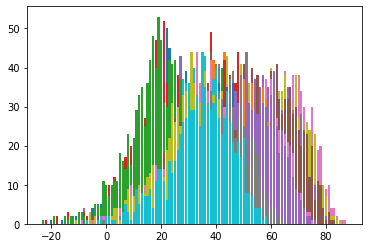

In [7]:
import matplotlib.pyplot as plt

for i in range(len(wage_res[0])):
    wages = [r[i] for r in wage_res]
    wage_x = list(set(wages))
    plt.bar(wage_x, [wages.count(w) for w in wage_x])
plt.show()

We have a couple of different distributions, each with varying means. None appear to be perfectly normally distributed, but there tends to be a bell-shape to each distribution. We can cycle through each distribution as follows:


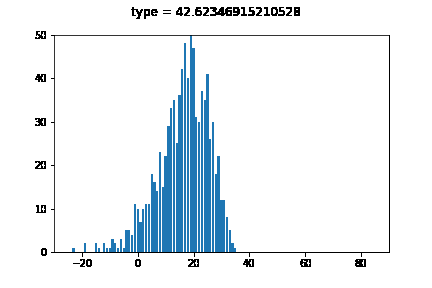

<Figure size 432x288 with 0 Axes>

In [8]:
from io import BytesIO
from PIL import Image

images = []
for i in range(len(wage_res[0])):
    plt.clf()
    fix, ax = plt.subplots()
    wages = [r[i] for r in wage_res]
    wage_x = list(set(wages))
    plt.bar(wage_x, [wages.count(w) for w in wage_x])
    filex = BytesIO()
    ax.figure.suptitle("type = " + str(types[i]))
    ax.set_xlim([-30,90])
    ax.set_ylim([0, 50])
    ax.figure.savefig(filex, format = "png")
    plt.close()
    filex.seek(0)
    images.append([types[i], filex])
    
images.sort(key = lambda x: x[0])
images = [im[1] for im in images]
    
imgs = [Image.open(image) for image in images]
masterfilex = BytesIO()
imgs[0].save(fp=masterfilex, format='GIF', append_images=imgs[1:], save_all=True, duration=100, loop=0)

# this is a GIF-displaying hack from https://stackoverflow.com/a/32108899
from IPython.display import HTML
from base64 import b64encode
HTML("<img src='data:image/gif;base64,{0}'/>".format(b64encode(masterfilex.getvalue()).decode('utf-8')))

This is the probability density function for the Hungarian Random Variable with $n = 30$ workers, $n = 30$ firms, firm productivities distributed as $N(1, 0.3)$ and worker types distributed as $N(75, 15^2)$ truncated between 0 and 100.

Most interestingly, this appears to imply the possible wages are distributed in a skewed bell curve which translates rightward as type increases. This seems to be indicative of a constant positive relationship between the mean of the data and the type of the worker, along with a constant standard deviation and skew. We can confirm this hypothesis by attempting to plot mean versus type with type as our dependent variable.

<Figure size 432x288 with 0 Axes>

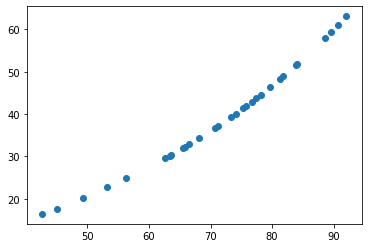

In [9]:
plt.clf()
fix, ax = plt.subplots()

avgs = []
for i in range(len(wage_res[0])):
    wages = [r[i] for r in wage_res]
    avgs.append(sum(wages)/len(wages))
    
plt.scatter(types, avgs)
plt.show()

Average wage seems to follow some sort of polynomial progression as type increases.

## Solving the Bellman Equation

Going back to the beginning, the Bellman Equation was:

$$v(w) = \max\limits_{\{\text{accept, reject}\}} \{\frac{w}{1-\beta}, c + \beta\int_0^\infty v(H)f(H)dH\}$$

Since $H$ is a discrete random variable with probability mass function $f(H)$, this is actually:

$$v(w) = \max\limits_{\{\text{accept, reject}\}} \{\frac{w}{1-\beta}, c + \beta\sum_{H \in \text{possible wages}} v(H)f(H)\}$$

$f(H)$ here must be normalized to between 0 and 1 in order for this to make sense, so given the frequencies of wages for a particularly typed worker, we can convert them into fractions as follows:

In [10]:
fractions = []
wageblobs = []

for i in range(len(wage_res[0])):
    wages = [r[i] for r in wage_res]
    wage_x = list(set(wages))
    wage_y = [wages.count(w)/len(wages) for w in wage_x]
    fractions.append(wage_y)
    wageblobs.append(wage_x)
    
print(list([sum(f) for f in fractions]))

[1.0, 0.9999999999999998, 0.9999999999999998, 0.9999999999999997, 1.0000000000000002, 1.0, 1.0, 0.9999999999999997, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 0.9999999999999997, 0.9999999999999998, 0.9999999999999999, 1.0000000000000002, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999999, 0.9999999999999997, 0.9999999999999998, 1.0, 0.9999999999999998, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999999]


All of these now approximately sum to one, which is what we need. We can now apply a numerical method for solving the Bellman equation.

The following code is a modification of the "Take 2" implementation of the basic McCall model in Python outlined in [QuantEcon](https://python.quantecon.org/mccall_model.html). We use it to compute the $\overline{w}$ threshold at which workers choose to accept job offers.

In [11]:
def solve_bellman(c, β, wages, weights):
    w = np.array(wages)
    q = np.array(weights)
    h = np.sum(w * q) / (1 - β)
    i = 0
    while True:
        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)
        if h == h_next:
            return (1 - β) * h_next
        
        h = h_next
    
wage = solve_bellman(13, 0.5, wageblobs[0], fractions[0])
wage

29.971048060220035

In [12]:
solve_bellman(16, 0.8, wageblobs[0], fractions[0])

42.67388688327317

In [13]:
solve_bellman(16, 0.2, wageblobs[0], fractions[0])

22.09961943138572

We have some clear data now, so we can plot the threshold wage for various values of the parameters.

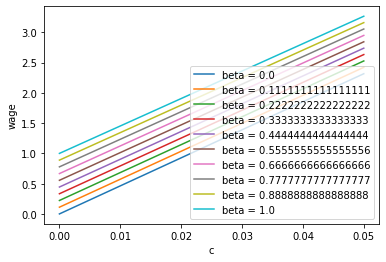

In [14]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots()
for beta in np.linspace(0, 1, 10):
    wages = []
    cs = np.linspace(0, 0.05, 30)
    for c in cs:
        wages.append(solve_bellman(beta, c, wageblobs[0], fractions[0]))
        
    plt.plot(cs, wages, label = "beta = " + str(beta))
    
ax.legend()
plt.xlabel("c")
plt.ylabel("wage")
plt.show()

As $\beta$ increases, the threshold wage increases linearly, at least here. The amount by which it increases appears to be directly correlated to the impact on wages, seeing as at $c = 0$ we scale from wage = 0 to wage = 1 as $\beta$ increases.

Additionally, there is a linear relation at this level between $c$ and the wage threshold as well. We can continue to run tests to see how.

In [15]:
def plot(clow, chigh, tol = 30):
    fig, ax = plt.subplots()
    for beta in np.linspace(0, 1, 10):
        wages = []
        cs = np.linspace(clow, chigh, tol)
        for c in cs:
            wages.append(solve_bellman(beta, c, wageblobs[0], fractions[0]))

        plt.plot(cs, wages, label = "beta = " + str(beta))

    ax.legend()
    plt.xlabel("c")
    plt.ylabel("wage")
    plt.show()

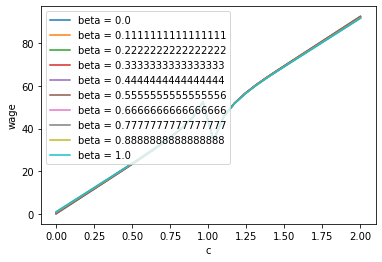

In [16]:
plot(0, 2, tol = 30)

There appears to be an asymptote for all values of $\beta$ at around $c = 1$.

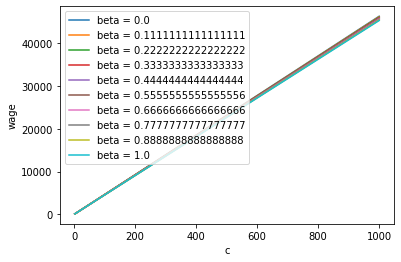

In [17]:
plot(2, 1000, tol = 30)

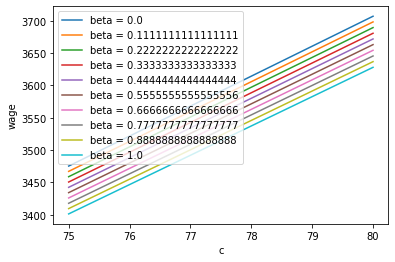

In [18]:
plot(75, 80, tol = 30)

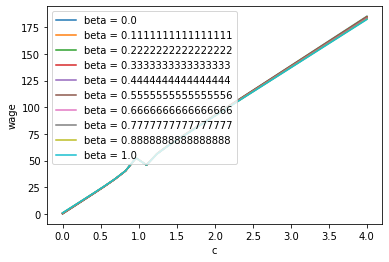

In [19]:
plot(0, 4, tol = 30)

After the asymptote, the function continues along the same linear trajectory. Now, we can do some analysis on $\beta$.

In [20]:
def plot(clow, chigh, tol = 30):
    fig, ax = plt.subplots()
    for c in np.linspace(clow, chigh, tol):
        wages = []
        betas = np.linspace(0, 1, 10)
        for beta in betas:
            wages.append(solve_bellman(beta, c, wageblobs[0], fractions[0]))

        plt.plot(betas, wages, label = "c = " + str(c))

    plt.xlabel("beta")
    plt.ylabel("wage")
    plt.show()

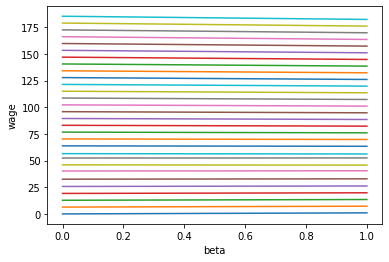

In [21]:
plot(0, 4)

We know that $c$ increases with wage. It's also apparent, apparently, that $\beta$ is linearly related.

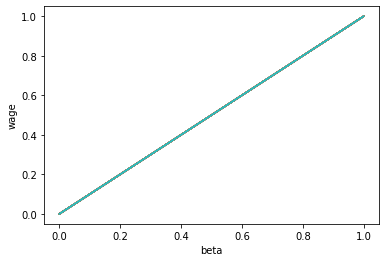

In [22]:
plot(0, 0.000001)

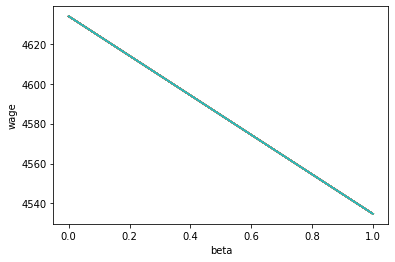

In [23]:
plot(100, 100.000001)

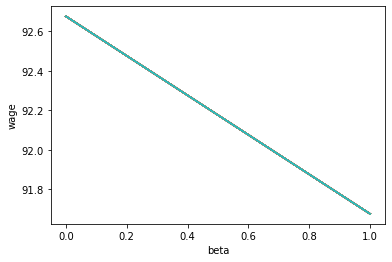

In [24]:
plot(2, 2.000001)

$\beta$'s relation to the equation isn't a very straightforward one.

We can also see how this holds for the wages of other types of workers.

In [25]:
def plot(clow, chigh, mytype, tol = 30):
    fig, ax = plt.subplots()
    for beta in np.linspace(0, 1, 10):
        wages = []
        cs = np.linspace(clow, chigh, tol)
        for c in cs:
            wages.append(solve_bellman(beta, c, wageblobs[mytype], fractions[mytype]))

        plt.plot(cs, wages, label = "beta = " + str(beta))

    ax.figure.suptitle("type = " + str(types[mytype]))
    plt.xlabel("c")
    plt.ylabel("wage")
    plt.show()

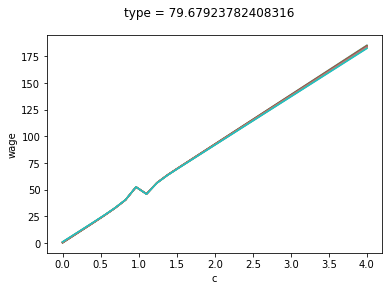

In [26]:
plot(0, 4, 0)

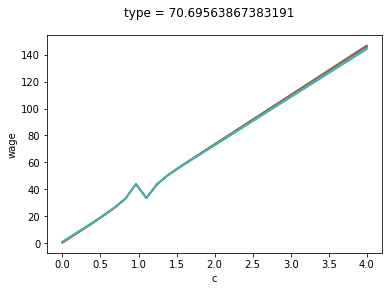

In [27]:
plot(0, 4, 1)

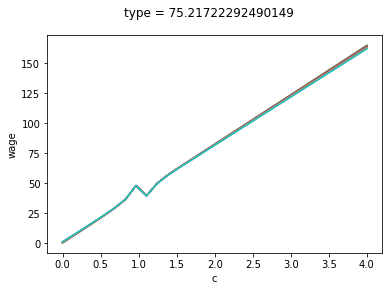

In [28]:
plot(0, 4, 2)

In [29]:
print(len(types))

30


To truly quantify the relation between types and wages, we must plot types directly on the grid. We do the following:

In [30]:
def plot(clow, chigh):
    fig, ax = plt.subplots()
    for beta in np.linspace(0, 1, 10):
        wages = []
        mytypes = []
        for mytype in range(len(types)):
            wages.append(solve_bellman(beta, 0.01, wageblobs[mytype], fractions[mytype]))
            mytypes.append(types[mytype])

        plt.scatter(mytypes, wages)
        
    plt.xlabel("types")
    plt.ylabel("wage")
    plt.show()

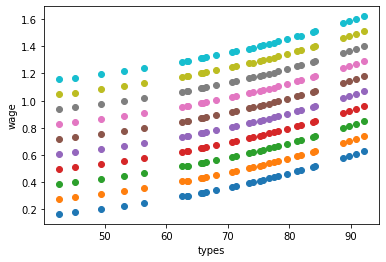

In [31]:
plot(0, 2)

Big observation: irrespective of $c$, $\beta$ is still related directly to the function by addition. Additionally, as type increases, wage level increases at a polynomial rate. We can now fix $\beta$ to determine the relation between $c$ and type.

In [32]:
def plot(clow, chigh):
    fig, ax = plt.subplots()
    for c in np.linspace(clow, chigh, 30):
        wages = []
        mytypes = []
        for mytype in range(len(types)):
            wages.append(solve_bellman(0.5, c, wageblobs[mytype], fractions[mytype]))
            mytypes.append(types[mytype])

        plt.scatter(mytypes, wages)
        
    plt.xlabel("types")
    plt.ylabel("wage")
    plt.show()

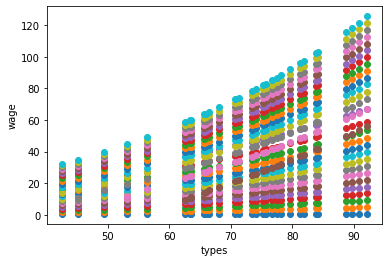

In [33]:
plot(0, 2)

Based on previous conclusions, we see $c$ continuing to be mostly linearly related to wage, with the slope of the relation being dependent on type, but type itself is more than linearly related to wage (but perhaps this is because of the impact of $c$). To end off, we can compute some coefficients by interpolating.

Regression from [this source](https://www.math.ubc.ca/~pwalls/math-python/linear-algebra/applications/#polynomial-interpolation).

-0.006912991046094353 0.9845602741715747
17.406023485473362 -0.9974559542691487
0.0001857610569179398 0.0004129260285866494
-0.45116324908317673 -6.803894782533901e-05
-1.2268107197344327e-06 -2.7159484473127523e-06
0.010243802015997415 4.475142323049603e-07


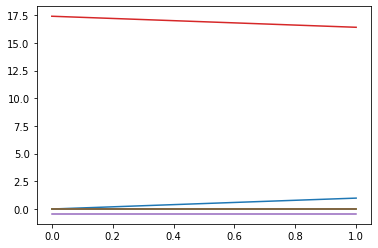

In [34]:
import scipy.linalg as la

co0 = []
co02 = []
co1 = []
co12 = []
co2 = []
co22 = []
for beta in np.linspace(0, 1, 30):
    c0 = []
    c1 = []
    c2 = []
    for c in np.linspace(2, 8, 30):
        mywages = [solve_bellman(beta, c, wageblobs[mytype], fractions[mytype]) for mytype in range(len(types))]
        t = np.array(types)
        A = np.column_stack([np.ones(len(types)),types,types**2])
        c = la.solve(A.T @ A,A.T @ mywages)
        c0.append(c[0])
        c1.append(c[1])
        c2.append(c[2])

    A = np.column_stack([np.ones(30), np.linspace(2, 8, 30)])
    c = la.solve(A.T @ A,A.T @ np.array(c0))
    co0.append(c[0])
    co02.append(c[1])

    c = la.solve(A.T @ A,A.T @ np.array(c1))
    co1.append(c[0])
    co12.append(c[1])

    c = la.solve(A.T @ A,A.T @ np.array(c2))
    co2.append(c[0])
    co22.append(c[1])
        
data = []
A = np.column_stack([np.ones(30), np.linspace(0, 1, 30)])
c = la.solve(A.T @ A,A.T @ np.array(co0))
print(c[0], c[1])
data += [c[0], c[1]]
c = la.solve(A.T @ A,A.T @ np.array(co02))
print(c[0], c[1])
data += [c[0], c[1]]
c = la.solve(A.T @ A,A.T @ np.array(co1))
print(c[0], c[1])
data += [c[0], c[1]]
c = la.solve(A.T @ A,A.T @ np.array(co12))
print(c[0], c[1])
data += [c[0], c[1]]
c = la.solve(A.T @ A,A.T @ np.array(co2))
print(c[0], c[1])
data += [c[0], c[1]]
c = la.solve(A.T @ A,A.T @ np.array(co22))
print(c[0], c[1])
data += [c[0], c[1]]
    
a = np.linspace(0, 1, 30)
plt.plot(a, co0)
plt.plot(a, co1)
plt.plot(a, co2)
plt.plot(a, co02)
plt.plot(a, co12)
plt.plot(a, co22)
plt.show()

This interpolates a quadratic polynomial to our data for each value of $c$ from 2 to 8 for all $\beta$ from 0 to 1, which we expect to be mostly linear in both. The polynomial is of the form $a_0(c, \beta) + a_1(c, \beta) * t + a_2(c, \beta) * t^2$ for type $t$. Each of $a_0, a_1, a_2$ appears to be a linear function of $c$ and $\beta$ with some particular slope. Using the interpolated coefficients, we get a function with some coefficients. Due to rounding, these coefficients change every time the program runs so we can't really use it to define an explicit equation.

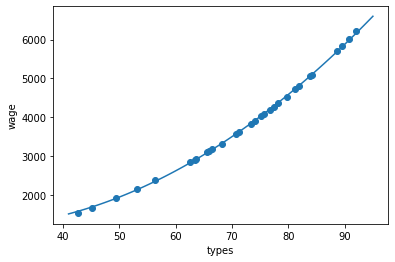

In [35]:
def plot(c, beta):
    fig, ax = plt.subplots()
    wages = []
    mytypes = []
    for mytype in range(len(types)):
        wages.append(solve_bellman(beta, c, wageblobs[mytype], fractions[mytype]))
        mytypes.append(types[mytype])

    def f(t, cx, beta):
        res = ((data[0] + data[1]*beta) + (data[2] + data[3]*beta)*cx)
        res += ((data[4] + data[5]*beta) + (data[6] + data[7]*beta)*cx) * t
        res += ((data[8] + data[9]*beta) + (data[10] + data[11]*beta)*cx) * t**2
        return res

    x = np.linspace(41, 95, 100)
    y = f(x, c, beta)
    plt.plot(x, y)
    plt.scatter(mytypes, wages)
        
    plt.xlabel("types")
    plt.ylabel("wage")
    plt.show()
    
plot(100, 1)

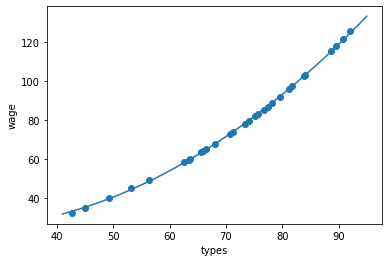

In [36]:
plot(2, 0.5)

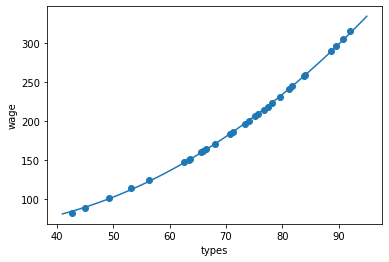

In [37]:
plot(5, 0)

In [38]:
st = f"(({data[0]}+{data[1]}b) + ({data[2]}+{data[3]}b)c)"
st += f" + (({data[4]}+{data[5]}b) + ({data[6]}+{data[7]}b)c)tw"
st += f" + (({data[8]}+{data[9]}b) + ({data[10]}+{data[11]}b)c)tw^2"
print(st)

((-0.006912991046094353+0.9845602741715747b) + (17.406023485473362+-0.9974559542691487b)c) + ((0.0001857610569179398+0.0004129260285866494b) + (-0.45116324908317673+-6.803894782533901e-05b)c)tw + ((-1.2268107197344327e-06+-2.7159484473127523e-06b) + (0.010243802015997415+4.475142323049603e-07b)c)tw^2


In the example that was run at the time of writing, the $t_w^2$ term had coefficient $ac$ for constant $a$, the $t_w$ term was the same albeit with some small intercept dependence on $\beta$, and the intercept term was largely dependent on an intercept, on $\beta$, on $c$, and on $\beta c$.

Note a **very important assumption** with the above work: $c \geq 2$. If $c < 2$, we encounter an asymptote at $c = 1$ as seen in the above work, and we wish to avoid having to account for that when we could use a much simpler function that's linear in $c$. Since the average wages tend to be much much higher anyways, we would expect unemployment benefits to be somewhat greater than just 2 monetary units and so this is a valid assumption.

In the end, this model ends up being dependent on $c$, $\beta$ and $t_w$ for a particular worker alongside all the state variables we had earlier. Thus, this function is only applicable in the particular state we chose. Recall this state was the state where:
- $n = 30$ firms
- $m = 30$ workers
- $N(1, 0.3)$ distribution of firm productivities
- $N(75, 15^2)$ distribution of worker types in $[0, 100]$

Therefore, it should be safe to conclude a general equation for $w$ is of the form:

$$w(n, m, \mu, \sigma^2, \mu', \sigma', a, b, c, \beta, t_w)$$

where $a$ is the worker type lower bound, $b$ is the worker type upper bound, and $\mu$, $\mu'$ correspond to means of the distributions of firms and workers respectively. Similar for the variances.

Due to the sheer number of parameters, it is infeasible to compute a universally general form for the optimal wage $w$. What we can do instead however is create a Python function to compute the optimal $w$ function for arbitrary $c \geq 2$, $\beta$ and $t_w$ given the other parameters. This is a combination of all the code we used above.

In [39]:
"""

Competitive McCall Job Search Model by James Yuming Yu
13 March 2021

Uses the Hungarian Algorithm applied to normal distributions as a random variable to fuel the McCall search model.

"""

from hungarianalg.alg import hungarian
import numpy as np
import scipy.linalg as la
import scipy.stats as stats
from sympy import *

def hungarian_rv(mu, var, mup, sigp, n, m, a, b):
    """
    Computes n * m sample draws of the Hungarian Random Variable as described in the reading.
    
    mu = population mean of firm productivities
    var = population variance of firm productivities
    mup = population mean of worker types
    sigp = population standard deviation of worker types
    n = number of firms
    m = number of workers
    a = minimum worker type
    b = maximum worker type
    
    Returns an n*m sample distribution of optimal matchings between the n workers and m firms.
    """
    
    # Compute sampling distribution of sample mean and sample variance 
    # from population mean and population variance of productivity factor of firms.
    sample_mu = np.random.normal(mu, var/n, n)
    sample_var = np.random.chisquare(n-1, size = n) * var / (n - 1)
    
    # Use the sampling distributions to construct random samples from the population.
    
    distributions = []

    for _mu in sample_mu:
        for _var in sample_var:
            distributions.append(np.random.normal(_mu, _var, n))
            
    distributions = np.array(distributions)
    
    # Compute population distribution of worker types.
    types = stats.truncnorm((a - mup) / sigp, (b - mup) / sigp, loc=mup, scale=sigp).rvs(m)
    
    # Evaluate Hungarian Algorithm with revenue function R(tw, rf) = tw * rf 
    # over distributions of workers and all sample distributions of firms.
    wage_results = []
    for sample in distributions:
        # Run the revenue function. 
        # If we have more workers than firms or firms than workers, add degenerate zero-revenue agents.
        matrx = np.outer(np.append(types, np.zeros(max(n - m, 0))), np.append(sample, np.zeros(max(m - n, 0))))
        # Run the Hungarian Algorithm on our sample combination.
        result = hungarian(np.rint(matrx))
        # Extract the optimal wages.
        wage_results.append(result.row_weights)
        
    return wage_results, types
   
    
def hungarian_rv_pdf(hrv):
    """Computes the PDF of a sample distribution of the Hungarian Random Variable."""
   
    wages = []
    weights = []
    # For all worker types in the optimal matching returned by a sample of the HRV, 
    # compute the frequencies of wages received.
    for i in range(len(hrv[0])):
        # Get wages for type i from all samples in the HRV distribution.
        loc_wages = [r[i] for r in hrv]
        wage_x = list(set(loc_wages))
        # Compute the frequencies of the wages.
        wage_y = [loc_wages.count(w)/len(loc_wages) for w in wage_x]
        wages.append(wage_x)
        weights.append(wage_y)

    return wages, weights


def solve_bellman(c, β, wages, weights):
    """Solves the Bellman equation for the optimal wage w above which to accept job offers in the competitive McCall model."""
    
    # Determine an initial guess for expected wage tomorrow.
    w = np.array(wages)
    q = np.array(weights)
    h = np.sum(w * q) / (1 - β)
    i = 0
    while True:
        # Iterate until the guess converges.
        s = np.maximum(w / (1 - β), h)
        h_next = c + β * np.sum(s * q)
        if h == h_next:
            return (1 - β) * h_next
        
        h = h_next
    

def regress_solution(types, wages, weights):
    """Computes the coefficients of the multivariate polynomial which determines the threshold wage w for parameters c, β, worker_type."""
    
    co0 = []
    co02 = []
    co1 = []
    co12 = []
    co2 = []
    co22 = []
    # Iterate for all beta.
    for beta in np.linspace(0, 1, 30):
        c0 = []
        c1 = []
        c2 = []
        # Iterate for all c.
        for c in np.linspace(2, 8, 30):
            # Regress a quadratic polynomial to the optimal wage threshold for each worker type given beta and c.
            mywages = [solve_bellman(beta, c, wages[mytype], weights[mytype]) for mytype in range(len(types))]
            t = np.array(types)
            A = np.column_stack([np.ones(len(types)),types,types**2])
            c = la.solve(A.T @ A,A.T @ mywages)
            c0.append(c[0])
            c1.append(c[1])
            c2.append(c[2])

        # Regress a linear polynomial in c for the coefficients of the quadratic polynomial in worker type.
        A = np.column_stack([np.ones(30), np.linspace(2, 8, 30)])
        c = la.solve(A.T @ A,A.T @ np.array(c0))
        co0.append(c[0])
        co02.append(c[1])
        c = la.solve(A.T @ A,A.T @ np.array(c1))
        co1.append(c[0])
        co12.append(c[1])
        c = la.solve(A.T @ A,A.T @ np.array(c2))
        co2.append(c[0])
        co22.append(c[1])

    # Regress a linear polynomial in beta for the coefficients of the linear-quadratic polynomial in worker type and c.
    data = []
    A = np.column_stack([np.ones(30), np.linspace(0, 1, 30)])
    c = la.solve(A.T @ A,A.T @ np.array(co0))
    data += [c[0], c[1]]
    c = la.solve(A.T @ A,A.T @ np.array(co02))
    data += [c[0], c[1]]
    c = la.solve(A.T @ A,A.T @ np.array(co1))
    data += [c[0], c[1]]
    c = la.solve(A.T @ A,A.T @ np.array(co12))
    data += [c[0], c[1]]
    c = la.solve(A.T @ A,A.T @ np.array(co2))
    data += [c[0], c[1]]
    c = la.solve(A.T @ A,A.T @ np.array(co22))
    data += [c[0], c[1]]
    return data


def fancy_print(data, should_round = False):
    """Prints a fancy equation given coefficients of the trivariate linear-quadratic polynomial solution to the Bellman equation."""
    beta, c, t = symbols("beta c t")
    dat = data.copy()
    if should_round: dat = [round(d, 4) for d in dat]
    res = ((dat[0]+dat[1]*beta) + (dat[2]+dat[3]*beta)*c)
    res += ((dat[4]+dat[5]*beta) + (dat[6]+dat[7]*beta)*c)*t
    res += ((dat[8]+dat[9]*beta) + (dat[10]+dat[11]*beta)*c)*t**2
    return res

In [40]:
mu = 1
var = 0.3
n = 30
mup = 75
sigp = 15
m = 30
a = 0
b = 100
hrv, _types = hungarian_rv(mu, var, mup, sigp, n, m, a, b)
_wages, _weights = hungarian_rv_pdf(hrv)
_data = regress_solution(_types, _wages, _weights)

fancy_print(_data, True)

0.8321*beta + 0.0143*c*t**2 + c*(29.2368 - 0.9724*beta) + t*(0.0045*beta + c*(-0.0007*beta - 0.9491) + 0.0059) - 0.2189

In [41]:
fancy_print(_data)

0.832149691869125*beta + c*(29.2368183489859 - 0.972420864775094*beta) + t**2*(-2.94410448762379e-5*beta + c*(4.83694592473084e-6*beta + 0.0142777640960783) - 3.85915014348366e-5) + t*(0.00447541892657928*beta + c*(-0.000735310022558232*beta - 0.949054705507298) + 0.00585286128302078) - 0.218906222143192

We can check derivatives to see how this function changes.

In [42]:
equation = fancy_print(_data, True)
diff(equation, symbols("beta"))

-0.9724*c + t*(0.0045 - 0.0007*c) + 0.8321

In [43]:
diff(equation, symbols("t"))

0.0045*beta + 0.0286*c*t + c*(-0.0007*beta - 0.9491) + 0.0059

In [44]:
diff(equation, symbols("c"))

-0.9724*beta + 0.0143*t**2 + t*(-0.0007*beta - 0.9491) + 29.2368

A bit confusing is why the function is decreasing in $\beta$ when $c$ is high. If we want, we can try plugging in some numbers to see what might be happening.

In [45]:
print(_wages[0])
solve_bellman(0.1, 0, _wages[0], _weights[0])

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 52.0, -26.0, -25.0, -23.0, -14.0, -13.0, -11.0, -1.0, -9.0, -7.0, -6.0, -5.0, -2.0]


0.1

In [46]:
solve_bellman(0.1, 0.5, _wages[0], _weights[0])

13.120000000000001

In [47]:
solve_bellman(20, 0, _wages[0], _weights[0])

20.0

In [48]:
solve_bellman(20, 0.5, _wages[0], _weights[0])

24.93145743145743

In [49]:
print(_types[0])

61.262704300802966


Most likely, this is the reason: when the type is high enough, its value exceeds the reduction caused by a high level of $c$ in the derivative of the wage function with respect to $\beta$. As a result, the derivative is always positive and so increasing $\beta$ increases the wage level, as needed.

Finally, we can see what happens when we increase type.

In [50]:
print(_types[1])

76.05914491217207


In [51]:
solve_bellman(20, 0, _wages[1], _weights[1])

20.0

In [52]:
solve_bellman(20, 0.5, _wages[1], _weights[1])

30.94176581089543

Indeed, when $\beta = 0$, a worker discounts the future entirely and will take whatever wage they get independent of type as long as it exceeds unemployment benefits. But if they have more patience i.e. higher $\beta$, they are willing to wait for a higher wage. By the optimal matching of the Hungarian Algorithm in the Hungarian Random Variable, higher type induces a matching with higher wages, which is what we see here.

One other thing we could try is varying the other model parameters such as the mean and variance of the input distributions. Unfortunately, each change requires a computationally intensive recalculation of the HRV distribution, so we can't include particularly many here.

In [53]:
mu = 2 # we changed this
var = 0.3
n = 30
mup = 75
sigp = 15
m = 30
a = 0
b = 100
hrv, _types = hungarian_rv(mu, var, mup, sigp, n, m, a, b)
_wages, _weights = hungarian_rv_pdf(hrv)
print(_types[0])
solve_bellman(20, 0.5, _wages[0], _weights[0])

64.92555401183024


59.43857698721512

Given time, one could run an iteration of the HRV for a set of all $\mu$, $\sigma^2$, $\mu'$, $\sigma'$ and regress the coefficients of the resulting closed-form equations over all model parameters. This is severely computationally intensive and is left as an exercise to the reader.

## Conclusion

A competitive version of the McCall Job Search model provides intuitive results regarding the impact of exogenous factors on job searching.

Using an environment (again, similar to the UBC Co-Op program) where:
- workers provide a type based on abilities,
- workers may discount the future,
- firms provide a productivity factor translating worker type into revenue,
- workers and firms know the distribution of all types and productivities in the market,
- worker types are normally distributed and constrained from 0 to 100,
- firm productivities are normally distributed,
- firms giving job offers are random samples of size $\geq$ 30 with:
    - normally distributed means, and
    - chi-square distributed variances;
- all workers apply to all available jobs when looking for jobs,
- firms make offers to workers following an optimal matching achievable through the Hungarian Algorithm, and
- workers can either accept the offer with a permanent wage or reject it and receive unemployment benefits

we have that:
- the resulting Hungarian Random Variable distribution of optimal wages for workers is a bell curve with mean increasing in type and constant variance (that is, higher type gives higher wages),
- given the distribution of workers and firms in the market, the optimal "reservation wage" above which a job offer should be accepted is:
    - increasing in unemployment benefits,
    - increasing in patience (decreasing in future discount intensity), 
    - increasing in worker type, and
    - exactly equal to the level of unemployment benefits when workers discount the future entirely;
- there is an asymptote where unemployment benefits is exactly equal to 1 which breaks certain aspects of the above conclusions; conclusions apply where unemployment benefits is at least equal to 2,
- given the distribution of workers and firms in the market, there exists an approximate closed-form solution to the reservation wage which is:
    - linear in future discounting, 
    - linear in unemployment benefits, and
    - quadratic in worker type;
- it may be possible to include the worker and firm type distributions in the closed-form approximation, but due to the computational intensity of the regression required, this is left as an exercise to the reader.

The most important conclusion here is that we see both patience and skills bring workers higher wages when workers are competing against each other.